#MIT 6.036 Spring 2019: Homework 3#

This colab notebook provides code and a framework for problems 1-7 of [the homework](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week3/week3_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


In [ ]:
!pwd

/content


In [ ]:
!rm -rf code_and_data_for_hw3*
!rm -rf mnist
!wget --quiet https://introml_oll.odl.mit.edu/6.036/static/homework/hw03/code_and_data_for_hw3.zip
!unzip code_and_data_for_hw3.zip
!mv code_and_data_for_hw3/* .

from code_for_hw3_part1 import *
import code_for_hw3_part2 as hw3

Archive:  code_and_data_for_hw3.zip
   creating: code_and_data_for_hw3/__pycache__/
  inflating: code_and_data_for_hw3/__pycache__/code_for_hw3_part2.cpython-36.pyc  
  inflating: code_and_data_for_hw3/auto-mpg.tsv  
  inflating: code_and_data_for_hw3/code_for_hw3_part1.py  
  inflating: code_and_data_for_hw3/code_for_hw3_part2.py  
  inflating: code_and_data_for_hw3/hw3_part2_main.py  
   creating: code_and_data_for_hw3/mnist/
  inflating: code_and_data_for_hw3/mnist/mnist_train0.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train1.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train2.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train3.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train4.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train5.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train6.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train7.png  
  inflating: code_and_data_for_hw3/mnist/mnist_train8.png  
  inflating: code_and_data_f

In [ ]:
help(tidy_plot)

Help on function tidy_plot in module code_for_hw3_part1:

tidy_plot(xmin, xmax, ymin, ymax, center=False, title=None, xlabel=None, ylabel=None)



# Feature Transformation

## <section>**Running Perceptron**</section>

In problems 1,2 and 3, you will have to run the Perceptron algorithm several times to obtain linear classifiers.
We provide you with an implementation of the algorithm which you can use to obtain your results.

The specifications for the `perceptron`method provided are:
* `data` is a numpy array of dimension $d$ by $n$
* `labels` is numpy array of dimension $1$ by $n$
* `params` is a dictionary specifying extra parameters to this algorithm; your algorithm runs a number of iterations equal to $T$
* `hook` is either None or a function that takes the tuple `(th, th0)` as an argument and displays the separator graphically.

It should return a tuple of $\theta$ (a $d$ by 1 array) and $\theta_0$ (a 1 by 1 array).

Note that you are free to modify the method. For example, a useful modification for this homework would be to make the method return the number of mistakes made on the input data, while it runs.

In [ ]:
# Perceptron algorithm with offset.
# data is dimension d by n
# labels is dimension 1 by n
# T is a positive integer number of steps to run
def perceptron(data, labels, params = {}, hook = None):
    # if T not in params, default to 100
    T = params.get('T', 50)
    (d, n) = data.shape

    theta = np.zeros((d, 1)); theta_0 = np.zeros((1, 1))
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                theta = theta + y * x
                theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
    return theta, theta_0

def averaged_perceptron(data, labels, params = {}, hook = None):
    T = params.get('T', 50)
    (d, n) = data.shape

    theta = np.zeros((d, 1)); theta_0 = np.zeros((1, 1))
    theta_sum = theta.copy()
    theta_0_sum = theta_0.copy()
    for t in range(T):
        for i in range(n):
            x = data[:,i:i+1]
            y = labels[:,i:i+1]
            if y * positive(x, theta, theta_0) <= 0.0:
                theta = theta + y * x
                theta_0 = theta_0 + y
                if hook: hook((theta, theta_0))
            theta_sum = theta_sum + theta
            theta_0_sum = theta_0_sum + theta_0
    theta_avg = theta_sum / (T*n)
    theta_0_avg = theta_0_sum / (T*n)
    if hook: hook((theta_avg, theta_0_avg))
    return theta_avg, theta_0_avg


def eval_classifier(learner, data_train, labels_train, data_test, labels_test):
    th, th0 = learner(data_train, labels_train)
    return score(data_test, labels_test, th, th0)/data_test.shape[1]

def positive(x, th, th0):
    return np.sign(th.T@x + th0)

def score(data, labels, th, th0):
    return np.sum(positive(data, th, th0) == labels)

def xval_learning_alg(learner, data, labels, k):
    _, n = data.shape
    idx = list(range(n))
    np.random.seed(0)
    np.random.shuffle(idx)
    data, labels = data[:,idx], labels[:,idx]

    score_sum = 0
    s_data = np.array_split(data, k, axis=1)
    s_labels = np.array_split(labels, k, axis=1)
    for i in range(k):
        data_train = np.concatenate(s_data[:i] + s_data[i+1:], axis=1)
        labels_train = np.concatenate(s_labels[:i] + s_labels[i+1:], axis=1)
        data_test = np.array(s_data[i])
        labels_test = np.array(s_labels[i])
        score_sum += eval_classifier(learner, data_train, labels_train,
                                              data_test, labels_test)
    return score_sum/k

In [ ]:
auto_data_all = hw3.load_auto_data('auto-mpg.tsv')
features = [('cylinders', hw3.raw),
            ('displacement', hw3.raw),
            ('horsepower', hw3.raw),
            ('weight', hw3.raw),
            ('acceleration', hw3.raw),
            ('origin', hw3.raw)]
auto_data, auto_labels = hw3.auto_data_and_labels(auto_data_all, features)


avg and std {}
entries in one_hot field {}


In [ ]:
perceptron(auto_data, auto_labels, params = {'T':100}, hook = None)


(array([[  -40. ],
        [ -932. ],
        [24055. ],
        [ 1688. ],
        [  583.9],
        [  160. ]]),
 array([[45.]]))

## <section>1) Scaling</section>

In [ ]:
theta = np.array([0,1,0.5])


## <section>2D) Encoding Discrete Values</section>

It is common to encode sets of discrete values, for machine learning, not as a single multi-valued feature, but using a one hot encoding. So, if there are $k$ values in the discrete set, we would transform that single multi-valued feature into $k$ binary-valued features, in which feature $i$ has value $+1$ if the original feature value was $i$ and has value $0$ (or $-1$) otherwise.

Write a function `one_hot` that takes as input $x$, a single feature value (between $1$ and $k$), and $k$, the total possible number of values this feature can take on, and transform it to a numpy column vector of $k$ binary features using a one-hot encoding (remember vectors have zero-based indexing).

In [ ]:
def one_hot(x, k):
    # Your implementation here
    vect = np.zeros((k,1))
    vect[x-1][0] = 1
    return vect

In [ ]:
test_one_hot(one_hot)

Passed! 



## 3) Polynomial Features

One systematic way of generating non-linear transformations of your input features is to consider the polynomials of increasing order.  Given a feature vector $x = [x_1, x_2, ..., x_d]^T$, we can map it into a new feature vector that contains all the factors in a polynomial of order $d$. For example, for $x = [x_1, x_2]^T$ and order 2, we get $$\phi(x) = [1, x_1, x_2, x_1x_2, x_1^2, x_2^2]^T$$ and for order 3, we get $$\phi(x) = [1, x_1, x_2, x_1x_2, x_1^2, x_2^2, x_1^2x_2, x_1x_2^2, x_1^3, x_2^3]^T.$$  

In the code that has been loaded, we have defined `make_polynomial_feature_fun` that, given the order, returns a feature transformation function (analogous to $\phi$ in the description).  You should use it in doing this problem.

In [ ]:
## For example, make_polynomial_feature_fun could be used as follows:
import numpy as np

# Data
data = np.zeros((5,1))

# Generate transformation of order 2
transformation = make_polynomial_feature_fun(2)

# Use transformation on data
print(transformation(data))

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
data = np.zeros((2,1))
degrees =  [1, 10, 20, 30, 40, 50]
for deg in degrees :
  transformation = make_polynomial_feature_fun(deg)
  print(len(transformation(data)))


3
66
231
496
861
1326


Note that iterative animations, which update a plot within a loop, don't work the same way in colab, as with a local python console installation.  One workaround for colab to be able to show such plot iterations is to show all the plots, and this can be done for the test code using this patched function:

In [ ]:
def test_linear_classifier_with_features(dataFun, learner, feature_fun,
                             draw = True, refresh = True, pause = True):
    raw_data, labels = dataFun()
    data = feature_fun(raw_data) if feature_fun else raw_data
    if draw:
        def hook(params):
            ax = plot_data(raw_data, labels)   # create plot axis on each iteration
            (th, th0) = params
            predictor = lambda x1,x2: int(positive(feature_fun(cv([x1, x2])), th, th0))
            plot_nonlin_sep(
                predictor,
                ax = ax)
            plot_data(raw_data, labels, ax)
            plt.show()                         # force plot to push to the colab notebook and be displayed
            print('th', th.T, 'th0', th0)
            if pause: input('press enter here to continue:')
    else:
        hook = None
    th, th0 = learner(data, labels, hook = hook)
    if hook: hook((th, th0))
    print("Final score", int(score(data, labels, th, th0)))
    print("Params", np.transpose(th), th0)

def test_with_features(dataFun, order = 2, draw=True, pause=True):
    test_linear_classifier_with_features(
        dataFun,                        # data
        perceptron,                     # learner
        make_polynomial_feature_fun(order), # feature maker
        draw=draw,
        pause=pause)

Here's a test you can run to see plots:

<ipython-input-36-06cf89fd8036>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictor = lambda x1,x2: int(positive(feature_fun(cv([x1, x2])), th, th0))


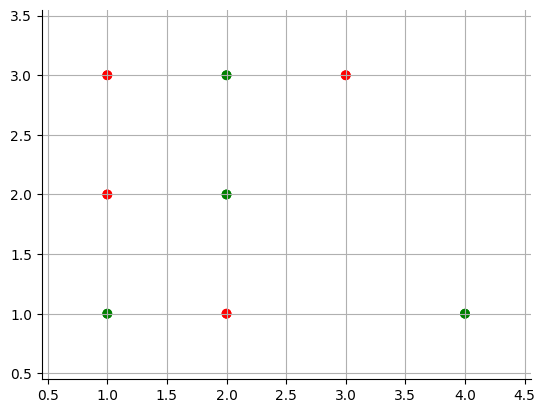

th [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] th0 [[1.]]


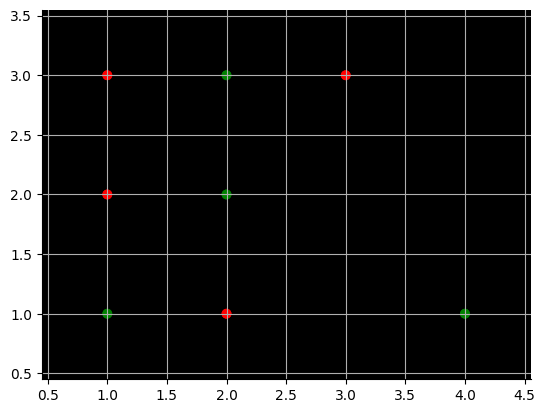

th [[ 0.  0. -1.  0. -1. -3.  0. -1. -3. -7.]] th0 [[0.]]


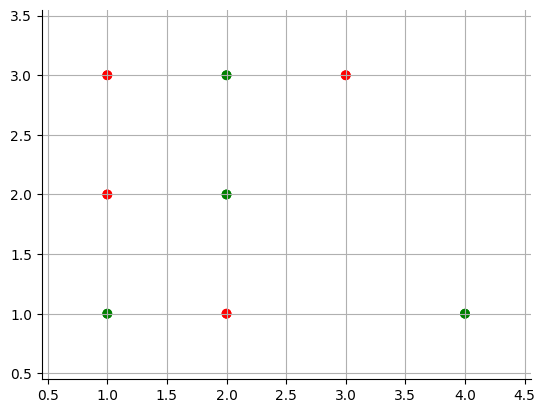

th [[ 1.  2.  2.  4.  5.  6.  8. 11. 15. 20.]] th0 [[1.]]


KeyboardInterrupt: 

In [ ]:
test_with_features(xor_more, order=3, draw=True, pause=False)

We know that a better way to do this exists (eg using [colab plot animations](https://colab.research.google.com/drive/131wXGA8h8d7llSZxZJ6R4e8nz0ih1WPG#scrollTo=5zVG8JcR4CS2)) - if you are willing to contribute some nice code which lets our plotting functions do this, please do share!

# Experiments

## 4) Evaluating algorithmic and feature choices for AUTO data

We now want to build a classifier for the auto data, focusing on the
numeric data.  In the code file for this part of the assignment, we have supplied you
with the `load_auto_data` function, that can be used to read the
relevant .tsv file.  It will return a list of dictionaries, one for each data item.

We then have to specify what feature function to use for each column
in the data.  The file `hw3_part2_main.py` has an example for constructing
the data and label arrays using `raw` feature function for all the columns.
Look at the definition of `features` in `hw3_part2_main.py`, this indicates a feature name to
use and then a feature function, there are three defined in the
`code_for_hw3_part2.py` file (`raw`, `standard` and `one_hot`).  `raw` just uses
the original value, `standard` subtracts out the mean value and
divides by the standard deviation and `one_hot` does the encoding
described in the notes.

The function `auto_data_and_labels` will process the dictionaries and
return <tt>data, labels</tt> where <tt>data</tt> are arrays of
dimension $(d, 392)$, with $d$ the total number of features specified,
and <tt>labels</tt> is of dimension $(1, 392)$.  The data in the file
is sorted by class, but it will be shuffled when you read it in.

In [ ]:
# Returns a list of dictionaries.  Keys are the column names, including mpg.
auto_data_all = hw3.load_auto_data('auto-mpg.tsv')

# The choice of feature processing for each feature, mpg is always raw and
# does not need to be specified.  Other choices are hw3.standard and hw3.one_hot.
# 'name' is not numeric and would need a different encoding.
features = [('cylinders', hw3.raw),
            ('displacement', hw3.raw),
            ('horsepower', hw3.raw),
            ('weight', hw3.raw),
            ('acceleration', hw3.raw),
            ## Drop model_year by default
            ## ('model_year', hw3.raw),
            ('origin', hw3.raw)]

# Construct the standard data and label arrays
auto_data, auto_labels = hw3.auto_data_and_labels(auto_data_all, features)
print('auto data and labels shape', auto_data.shape, auto_labels.shape)

avg and std {}
entries in one_hot field {}
auto data and labels shape (6, 392) (1, 392)


In [ ]:
from functools import partial
k = 10 #10-fold cross-validation
#learner = partial(perceptron, params={'T': 50})
learner = partial(averaged_perceptron, params={'T': 50})
print(xval_learning_alg(learner, auto_data, auto_labels, k))

0.8366025641025641


In [ ]:
# Returns a list of dictionaries.  Keys are the column names, including mpg.
auto_data_all = hw3.load_auto_data('auto-mpg.tsv')

# The choice of feature processing for each feature, mpg is always raw and
# does not need to be specified.  Other choices are hw3.standard and hw3.one_hot.
# 'name' is not numeric and would need a different encoding.
features = [('cylinders', hw3.one_hot),
            ('displacement', hw3.standard),
            ('horsepower', hw3.standard),
            ('weight', hw3.standard),
            ('acceleration', hw3.standard),
            ## Drop model_year by default
            ## ('model_year', hw3.raw),
            ('origin', hw3.one_hot)]

# Construct the standard data and label arrays
auto_data, auto_labels = hw3.auto_data_and_labels(auto_data_all, features)
print('auto data and labels shape', auto_data.shape, auto_labels.shape)

avg and std {'displacement': (388.3482142857143, 302.0458123396403), 'horsepower': (509.3545918367347, 333.6521151716361), 'weight': (2977.5841836734694, 848.3184465698365), 'acceleration': (15.541326530612228, 2.7553429127509963)}
entries in one_hot field {'cylinders': [3.0, 4.0, 5.0, 6.0, 8.0], 'origin': [1.0, 2.0, 3.0]}
auto data and labels shape (12, 392) (1, 392)


In [ ]:
k = 10 #10-fold cross-validation
#learner = partial(perceptron, params={'T': 1})
learner = partial(averaged_perceptron, params={'T': 1})
print(xval_learning_alg(learner, auto_data, auto_labels, k))

0.9004487179487182


## 5) Evaluating algorithmic and feature choices for review data

We have supplied you with the `load_review_data`
function, that can be used to read a .tsv file and return the labels
and texts. We have also supplied you with the `bag_of_words` function,
which takes the raw data and returns a dictionary of unigram
words. The resulting dictionary is an input to
`extract_bow_feature_vectors` which computes a feature matrix of ones
and zeros that can be used as the input for the classification
algorithms.  The file `hw3_part2_main.py` has code for constructing
the data and label arrays.  Using these arrays and our implementation
of the learning algorithms, you will be able to compute $\theta$ and
$\theta_0$.  You will need to add your (or the one written by staff)
implementation of perceptron and averaged perceptron.

In [ ]:
# Returns lists of dictionaries.  Keys are the column names, 'sentiment' and 'text'.
# The train data has 10,000 examples
review_data = hw3.load_review_data('reviews.tsv')

# Lists texts of reviews and list of labels (1 or -1)
review_texts, review_label_list = zip(*((sample['text'], sample['sentiment']) for sample in review_data))

# The dictionary of all the words for "bag of words"
dictionary = hw3.bag_of_words(review_texts)

# The standard data arrays for the bag of words
review_bow_data = hw3.extract_bow_feature_vectors(review_texts, dictionary)
review_labels = hw3.rv(review_label_list)
print('review_bow_data and labels shape', review_bow_data.shape, review_labels.shape)

review_bow_data and labels shape (19945, 10000) (1, 10000)


In [ ]:
T5_p = xval_learning_alg(partial(perceptron, params={'T': 1}), review_bow_data, review_labels, 10)
T5_a = xval_learning_alg(partial(averaged_perceptron, params={'T': 1}), review_bow_data, review_labels, 10)
print(T5_p, T5_a)

0.7672000000000001 0.8120999999999998


In [ ]:
T10_P = xval_learning_alg(partial(perceptron, params={'T': 10}), review_bow_data, review_labels, 10)
T10_a = xval_learning_alg(partial(averaged_perceptron, params={'T': 10}), review_bow_data, review_labels, 10)
print(T10_P, T10_a)

0.7871 0.8237


In [ ]:
T50_P = xval_learning_alg(perceptron, review_bow_data, review_labels, 10)
T50_a = xval_learning_alg(averaged_perceptron, review_bow_data, review_labels, 10)
print(T50_P, T50_a)

0.8036 0.8157


In [ ]:
# Best algorithm = averaged_perceptron # Best T = 10
theta, theta0 = averaged_perceptron(review_bow_data, review_labels, params = {'T': 10})

In [ ]:
top_10_indices = np.argsort(theta.flatten())[:10]
print(top_10_indices)

[ 305  492 2352 2003 2633 3126 2877 2571 1406 2424]


In [ ]:
keys = list(dictionary.keys())
keys_at_indices = [keys[i] for i in top_10_indices]
print(keys_at_indices)

['worst', 'awful', 'unfortunately', 'horrible', 'stuck', 'changed', 'disappointment', 'bland', 'poor', 'formula']


## 6) Evaluating features for MNIST data


This problem explores how well the perceptron algorithm works to <a
href="http://neuralnetworksanddeeplearning.com/chap1.html">classify
images of handwritten digits</a>, from the well-known ("MNIST")
dataset, buiding on your thoughts from lab about extracting features
from images.  This exercise will highlight how important feature
extraction is, before linear classification is done, using algorithms
such as the perceptron.

<b>Dataset setup</b>

Often, it may be easier to work with a vector whose spatial orientation is preserved.
In previous parts, we have represented features as one long feature vector.
For images, however, we often represent a $m$ by $n$ image
as a `(m,n)` array, rather than a `(mn,1)` array
(as the previous parts have done).

In the code file, we have supplied you with the `load_mnist_data` function,
which will read from the provided image files and populate a dictionary,
with image and label vectors for each numerical digit from 0 to 9.
These images are already shaped as `(m,n)` arrays.

In [ ]:
mnist_data_all = hw3.load_mnist_data(range(10))

print('mnist_data_all loaded. shape of single images is', mnist_data_all[0]["images"][0].shape)

# HINT: change the [0] and [1] if you want to access different images
d0 = mnist_data_all[0]["images"]
d1 = mnist_data_all[1]["images"]
y0 = np.repeat(-1, len(d0)).reshape(1,-1)
y1 = np.repeat(1, len(d1)).reshape(1,-1)

# data goes into the feature computation functions
data = np.vstack((d0, d1))
# labels can directly go into the perceptron algorithm
labels = np.vstack((y0.T, y1.T)).T

mnist_data_all loaded. shape of single images is (28, 28)


In [ ]:
# change these implementations to support whole datasets

def raw_mnist_features(x):
    """
    @param x (n_samples,m,n) array with values in (0,1)
    @return (m*n,n_samples) reshaped array where each entry is preserved
    """
    n_samples,m,n = x.shape
    return x.reshape(n_samples, m*n).T

def row_average_features(x):
    """
    This should either use or modify your code from the tutor questions.

    @param x (n_samples,m,n) array with values in (0,1)
    @return (m,n_samples) array where each entry is the average of a row
    """
    return np.mean(x,axis=2).T



def col_average_features(x):
    """
    This should either use or modify your code from the tutor questions.

    @param x (n_samples,m,n) array with values in (0,1)
    @return (n,n_samples) array where each entry is the average of a column
    """
    return np.mean(x,axis=1).T


def top_bottom_features(x):
    """
    This should either use or modify your code from the tutor questions.

    @param x (n_samples,m,n) array with values in (0,1)
    @return (2,n_samples) array where the first entry of each column is the average of the
    top half of the image = rows 0 to floor(m/2) [exclusive]
    and the second entry is the average of the bottom half of the image
    = rows floor(m/2) [inclusive] to m
    """
    m = x.shape[1]
    top_half = np.mean(x[:, :m//2, :], axis=(1, 2))  # Average of the top half
    bottom_half = np.mean(x[:, m//2:, :], axis=(1, 2))  # Average of the bottom half
    return np.vstack((top_half, bottom_half))

In [ ]:
# use this function to evaluate accuracy
acc = hw3.get_classification_accuracy(raw_mnist_features(data), labels)
print(acc)

0.975


In [ ]:
# HINT: change the [0] and [1] if you want to access different images
d0 = mnist_data_all[9]["images"]
d1 = mnist_data_all[0]["images"]
y0 = np.repeat(-1, len(d0)).reshape(1,-1)
y1 = np.repeat(1, len(d1)).reshape(1,-1)

# data goes into the feature computation functions
data = np.vstack((d0, d1))
# labels can directly go into the perceptron algorithm
labels = np.vstack((y0.T, y1.T)).T

# use this function to evaluate accuracy
acc = hw3.get_classification_accuracy(raw_mnist_features(data), labels)
print(acc)

0.6470833333333333


In [ ]:
# HINT: change the [0] and [1] if you want to access different images
d0 = mnist_data_all[9]["images"]
d1 = mnist_data_all[0]["images"]
y0 = np.repeat(-1, len(d0)).reshape(1,-1)
y1 = np.repeat(1, len(d1)).reshape(1,-1)

# data goes into the feature computation functions
data = np.vstack((d0, d1))
# labels can directly go into the perceptron algorithm
labels = np.vstack((y0.T, y1.T)).T

# use this function to evaluate accuracy
acc = hw3.get_classification_accuracy(row_average_features(data), labels)
acc1 = hw3.get_classification_accuracy(col_average_features(data), labels)
acc2 = hw3.get_classification_accuracy(top_bottom_features(data), labels)
print([acc,acc1,acc2])

[0.49749999999999994, 0.5041666666666667, 0.49749999999999994]
